# DAT200 CA5 2022

Kaggle username: JisooPark

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

import warnings # ignore warning message
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Reading data

In [2]:
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

print('train: ', train.shape, '\ntest: ', test.shape)

train:  (12165, 13) 
test:  (5214, 12)


### Data exploration and visualisation

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Season                               12165 non-null  object
 1   Year                                 12165 non-null  object
 2   Month                                12165 non-null  object
 3   Hour                                 12165 non-null  object
 4   Holiday                              12165 non-null  object
 5   Weekday                              12165 non-null  object
 6   Working day                          12165 non-null  object
 7   Weather situation                    12165 non-null  object
 8   Temperature (normalized)             12165 non-null  object
 9   Feels-like temperature (normalized)  12165 non-null  object
 10  Humidity (normalized)                12165 non-null  object
 11  Windspeed                            1216

In [4]:
import re
# change the variable names
columns = list(train.columns)
for col in columns:
    train = train.rename(
        columns = {
            col: re.sub(r'[\-|\(\)\[\]`]', '', col).strip().replace(' ', '_').lower()
        })
columns = list(test.columns)
for col in columns:
    test = test.rename(
        columns = {
            col: re.sub(r'[\-|\(\)\[\]`]', '', col).strip().replace(' ', '_').lower()
        })

In [5]:
print('column name of Train: \n',train.columns)
print("="*50)
print('column name of Test: \n',test.columns)

column name of Train: 
 Index(['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'working_day',
       'weather_situation', 'temperature_normalized',
       'feelslike_temperature_normalized', 'humidity_normalized', 'windspeed',
       'rental_bikes_count'],
      dtype='object')
column name of Test: 
 Index(['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'working_day',
       'weather_situation', 'temperature_normalized',
       'feelslike_temperature_normalized', 'humidity_normalized', 'windspeed'],
      dtype='object')


In [6]:
tr_cols = train.columns
tr_num_missing = (train[tr_cols] == 'missing').sum()
print('Train data:\n', tr_num_missing)
print("="*40)
te_cols = test.columns
te_num_missing = (test[te_cols] == 'missing').sum()
print('Test data:\n', te_num_missing)

Train data:
 season                              39
year                                37
month                               31
hour                                50
holiday                             30
weekday                             36
working_day                         34
weather_situation                   27
temperature_normalized              36
feelslike_temperature_normalized    24
humidity_normalized                 30
windspeed                           34
rental_bikes_count                   0
dtype: int64
Test data:
 season                              0
year                                0
month                               0
hour                                0
holiday                             0
weekday                             0
working_day                         0
weather_situation                   0
temperature_normalized              0
feelslike_temperature_normalized    0
humidity_normalized                 0
windspeed                           0

In [7]:
print('Train: \n',train.weather_situation.value_counts())
print("="*50)
print('Test: \n',test.weather_situation.value_counts())

Train: 
 Clear or partly cloudy                    7969
Misty and/or cloudy                       3170
Light snow or light rain                   997
missing                                     27
Heavy rain, heavy snow or thunderstorm       2
Name: weather_situation, dtype: int64
Test: 
 Clear or partly cloudy                    3422
Misty and/or cloudy                       1370
Light snow or light rain                   421
Heavy rain, heavy snow or thunderstorm       1
Name: weather_situation, dtype: int64


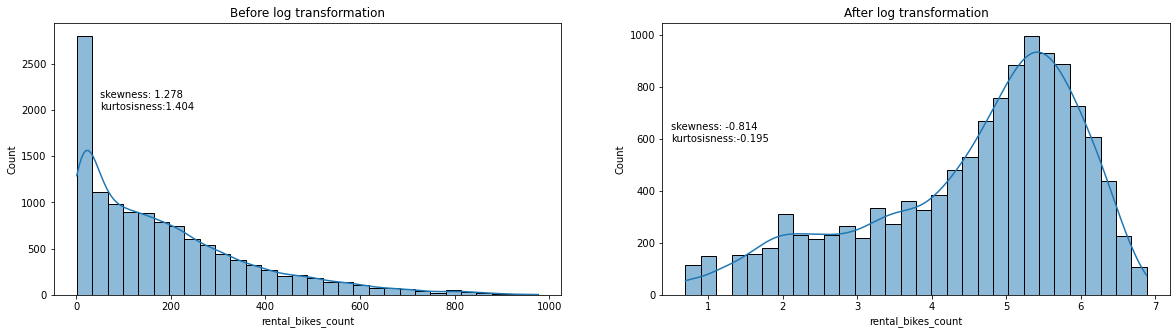

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 5))

sns.histplot(train['rental_bikes_count'], kde=True, bins=30, ax = ax1)
sns.histplot(np.log1p(train['rental_bikes_count']), kde=True, bins=30, ax = ax2)

ax1.set(title = 'Before log transformation')
ax1.annotate('skewness: {0} \nkurtosisness:{1}'.format(np.round(skew(train['rental_bikes_count']), 3), 
                                                       np.round(kurtosis(train['rental_bikes_count']), 3)), xy = (50, 2000))
ax2.set(title = 'After log transformation')
ax2.annotate('skewness: {0} \nkurtosisness:{1}'.format(np.round(skew(np.log1p(train['rental_bikes_count'])), 3), 
                                                       np.round(kurtosis(np.log1p(train['rental_bikes_count'])), 3)), xy = (0.5, 590))

plt.show()

Brief note:
   - missing data exists in the training data sets, but not in the test datasets. This will be eliminated or imputed with median values.
   - One of the categories in `weather_situation` only has 1 or 2 values(`Heavy rain, heavy snow or thunderstorm`) in the training and the testing data set. It will be combined with the `Light snow or light rain` category.
   - The target variable(`rental_bikes_count`) is highly skewed and it looks close to normal distribution after the log transformation.

### Data cleaning

In [9]:
# replace missing to nan and remove
tr = train[tr_cols].replace('missing', np.nan).dropna()
print('Removed number of data: ', train.shape[0] - tr.shape[0])

Removed number of data:  406


In [10]:
# There is no more missing variables
(tr[tr_cols] == 'missing').sum()

season                              0
year                                0
month                               0
hour                                0
holiday                             0
weekday                             0
working_day                         0
weather_situation                   0
temperature_normalized              0
feelslike_temperature_normalized    0
humidity_normalized                 0
windspeed                           0
rental_bikes_count                  0
dtype: int64

In [11]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11759 entries, 0 to 12164
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   season                            11759 non-null  object 
 1   year                              11759 non-null  float64
 2   month                             11759 non-null  float64
 3   hour                              11759 non-null  float64
 4   holiday                           11759 non-null  float64
 5   weekday                           11759 non-null  float64
 6   working_day                       11759 non-null  float64
 7   weather_situation                 11759 non-null  object 
 8   temperature_normalized            11759 non-null  float64
 9   feelslike_temperature_normalized  11759 non-null  float64
 10  humidity_normalized               11759 non-null  float64
 11  windspeed                         11759 non-null  float64
 12  rent

In [12]:
tr['weather_situation'].replace('Heavy rain, heavy snow or thunderstorm','Light snow or light rain',inplace = True)
test['weather_situation'].replace('Heavy rain, heavy snow or thunderstorm','Light snow or light rain',inplace = True)

print('train: \n',tr.weather_situation.value_counts())
print('test: \n',test.weather_situation.value_counts())

train: 
 Clear or partly cloudy      7718
Misty and/or cloudy         3082
Light snow or light rain     959
Name: weather_situation, dtype: int64
test: 
 Clear or partly cloudy      3422
Misty and/or cloudy         1370
Light snow or light rain     422
Name: weather_situation, dtype: int64


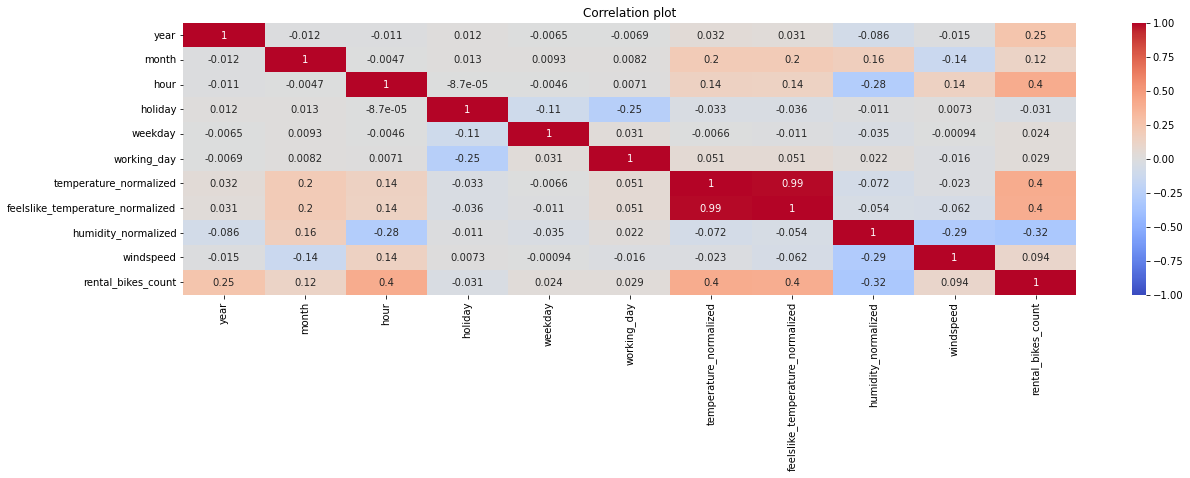

In [13]:
# correlation plot
plt.figure(figsize = (20, 5))
sns.heatmap(tr.corr(), annot = True, vmax = 1, vmin = -1, cmap = 'coolwarm')
plt.title("Correlation plot")
plt.show()

In [14]:
tr = tr.drop(['feelslike_temperature_normalized'], axis = 1)
print(tr.shape)
test = test.drop(['feelslike_temperature_normalized'], axis = 1)
print(test.shape)

(11759, 12)
(5214, 11)


Brief note 

   - In training data set, missing value existed as "missing" instead of NaN. The total number of missing values 406, and it removed from the data    
   - `temperature_normalized` and `feelslike_temperature_normalized` has nearly close to 1, thus we can remove either one of them to prevent multicolinearity problem

### Data exploration after cleaning

In [15]:
# change data type
tr[['year','month', 'hour', 'holiday', 'weekday', 'working_day']] = tr[['year','month', 'hour', 'holiday', 'weekday', 'working_day']].apply(np.int32)

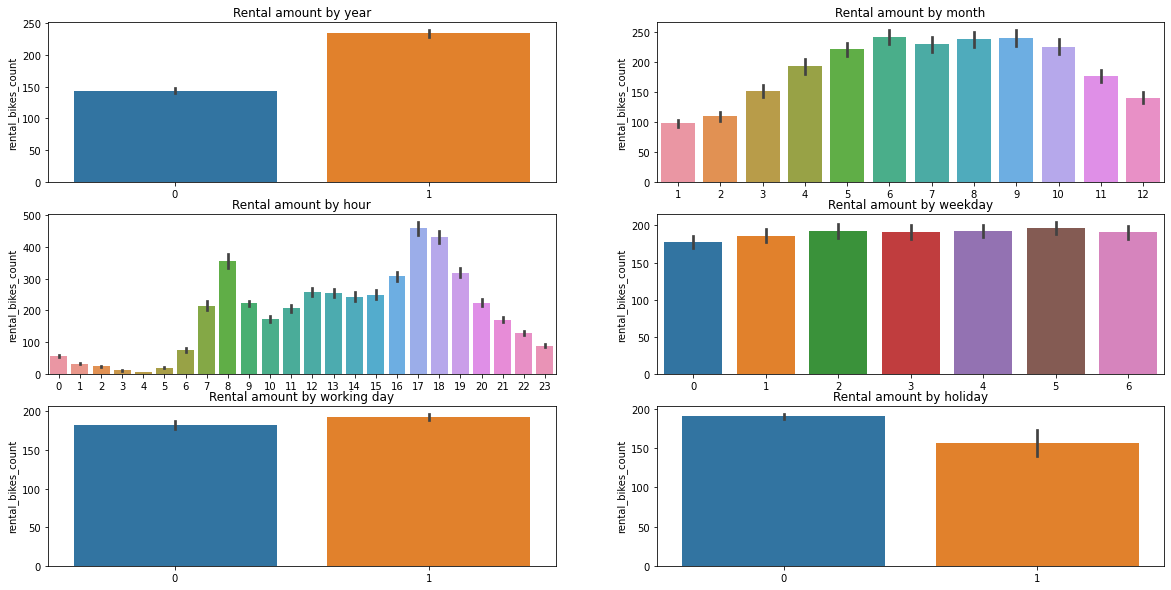

In [16]:
# barblots
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 10))

sns.barplot(data = tr, x = 'year', y = 'rental_bikes_count', ax = ax1)
sns.barplot(data = tr, x = 'month', y = 'rental_bikes_count', ax = ax2)
sns.barplot(data = tr, x = 'hour', y = 'rental_bikes_count', ax = ax3)
sns.barplot(data = tr, x = 'weekday', y = 'rental_bikes_count', ax = ax4)
sns.barplot(data = tr, x = 'working_day', y = 'rental_bikes_count', ax = ax5)
sns.barplot(data = tr, x = 'holiday', y = 'rental_bikes_count', ax = ax6)

ax1.set(xlabel = "", title = "Rental amount by year") 
ax2.set(xlabel = "", title = "Rental amount by month") 
ax3.set(xlabel = "", title = "Rental amount by hour") 
ax4.set(xlabel = "", title = "Rental amount by weekday") 
ax5.set(xlabel = "", title = "Rental amount by working day") 
ax6.set(xlabel = "", title = "Rental amount by holiday") 

plt.show()

- `year` shows that the number of rented bikes is increasing by the year.
- `hour` has two peak points at 8 am and 5-6 pm which is rush hour.
- `month` shows that summer(as a rule of thumbs, June, July, August) has more rented bikes than other months.
- `working_day` seems no differences between working day(0) and non-working day(neither weekend nor holiday; 1).
- `holiday` describes a non-holiday(1) has a slightly more number of rented bikes than a holiday(0).

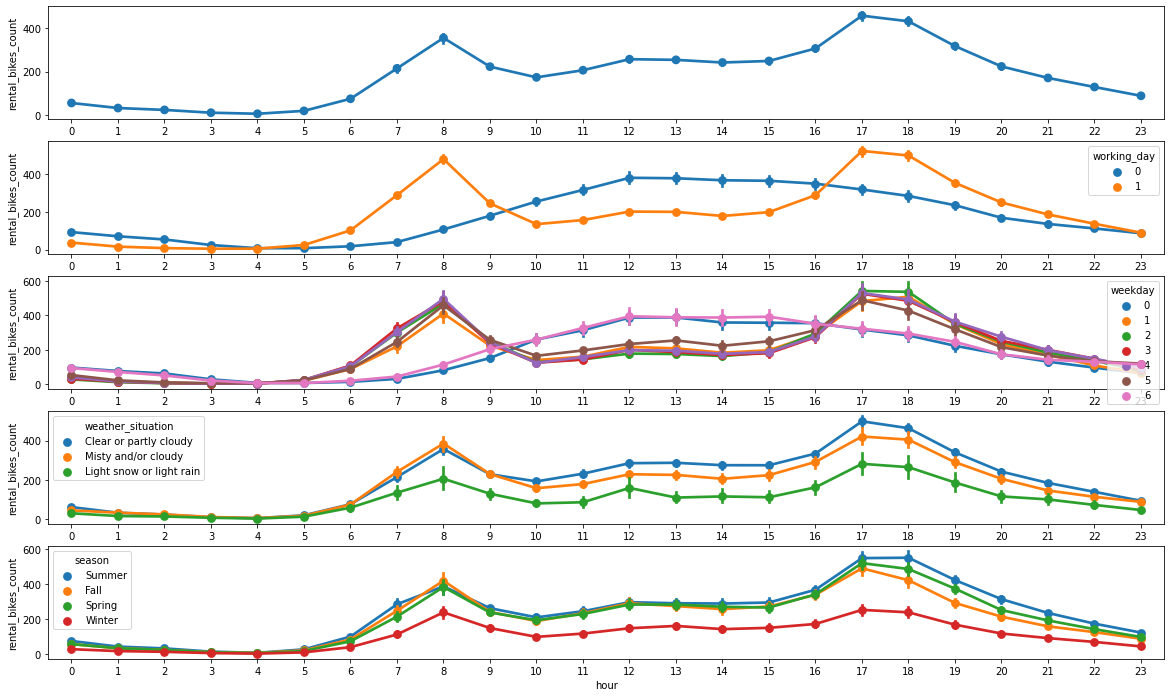

In [17]:
# Let's look at more detail by the hour
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5, figsize = (20, 12)) 

sns.pointplot(data = tr, x = "hour", y = "rental_bikes_count", ax = ax1) 
sns.pointplot(data = tr, x = "hour", y = "rental_bikes_count", hue = "working_day", ax = ax2) 
sns.pointplot(data = tr, x = "hour", y = "rental_bikes_count", hue = "weekday", ax = ax3) 
sns.pointplot(data = tr, x = "hour", y = "rental_bikes_count", hue = "weather_situation", ax = ax4) 
sns.pointplot(data = tr, x = "hour", y = "rental_bikes_count", hue = "season", ax = ax5)

plt.show()

- `working_day` and `weekday` shows similar pattern by the hour so they could be used as one of them.
- When the `weather_situation` is getting worse the number of rented bikes are decreasing
- `Winter` is the least used the rented bikes all the `season`.

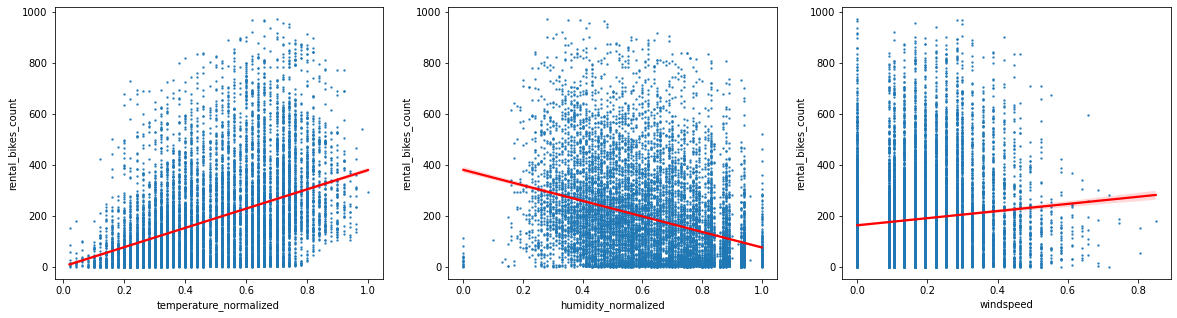

In [18]:
# plt.figure(figsize = (20, 7))
# sns.pairplot(tr[['temperature_normalized', 'humidity_normalized', 'windspeed', 'rental_bikes_count']],
#             kind="reg", corner=True, plot_kws={'line_kws':{'color':'red'}})
# plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(20,5))

temp_p = pd.concat([tr['rental_bikes_count'], tr['temperature_normalized']], axis = 1)
sns.regplot(x = 'temperature_normalized', y = 'rental_bikes_count', 
            data=temp_p, scatter= True, fit_reg=True, scatter_kws={'s': 2}, line_kws={'color': 'red'}, ax = ax1)

humi_p = pd.concat([tr['rental_bikes_count'], tr['humidity_normalized']], axis = 1)
sns.regplot(x = 'humidity_normalized', y = 'rental_bikes_count', 
            data=humi_p, scatter= True, fit_reg=True, scatter_kws={'s': 2}, line_kws={'color': 'red'}, ax = ax2)

wind_p = pd.concat([tr['rental_bikes_count'], tr['windspeed']], axis = 1)
sns.regplot(x = 'windspeed', y = 'rental_bikes_count', 
            data=wind_p, scatter= True, fit_reg=True, scatter_kws={'s': 2}, line_kws={'color': 'red'}, ax = ax3)

plt.show()


- `temperature_normalized`, and `windspeed` looks positive relationship, but `humidity_normalized` has negative relationship with the `rental_bikes_count`
- `windspeed` may need to feature engineering to impute 0 values because the wind is generally not 0 as a general rule.

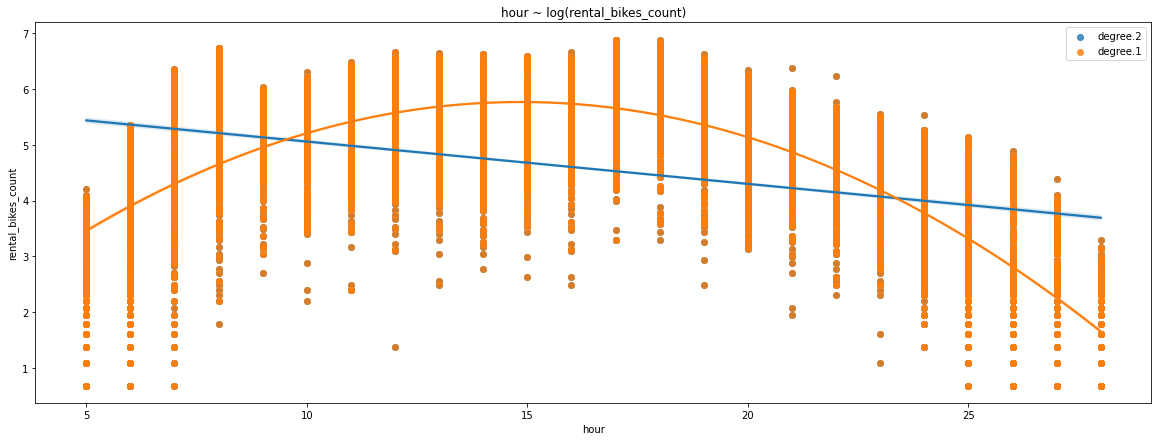

In [19]:
# polynomial relationship between hour and rental_bikes_count
tmp = tr.copy()
for i in [0, 1, 2, 3, 4]:
    tmp['hour'].replace(i, i + 24, inplace = True)

plt.figure(figsize = (20, 7))
sns.scatterplot(x = tmp['hour'], y = np.log1p(tmp['rental_bikes_count']))
plt.title('hour ~ log(rental_bikes_count)')
sns.regplot(x = tmp['hour'], y = np.log1p(tmp['rental_bikes_count']), order = 1, label = 'degree.2')
sns.regplot(x = tmp['hour'], y = np.log1p(tmp['rental_bikes_count']), order = 2, label = 'degree.1')
plt.legend(loc = 'best')
plt.show()

- `hour` is fitted with polynomial degree with 2. This may indicate polynomial regression will be suitable for this dataset.

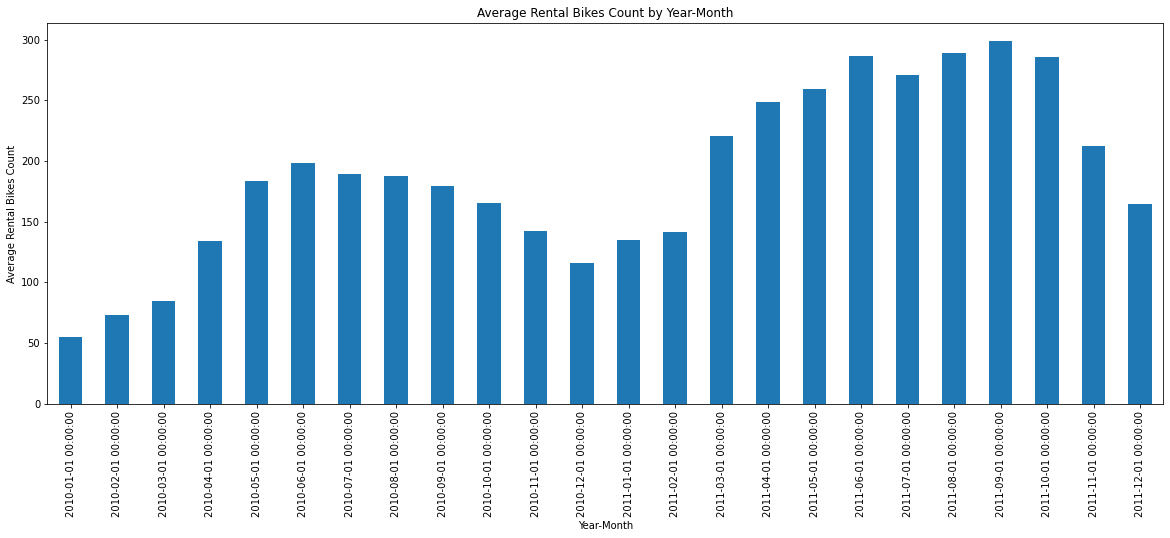

In [20]:
## time series
from datetime import datetime

tmp2 = tr.copy()

tmp2['yr'] = '201' + tmp2['year'].astype('str')
tmp2['month'] = tmp2['month'].astype('str')

tmp2['ym'] = tmp2[['yr', 'month']].apply(lambda x: '-'.join(x), axis =1)
tmp2['ym'] = tmp2['ym'].apply(lambda x: datetime.strptime(x, "%Y-%m"))

plt.figure(figsize = (20, 7))
tmp2.groupby('ym')['rental_bikes_count'].mean().plot(kind = 'bar', rot = 90)
plt.xlabel('Year-Month')
plt.ylabel('Average Rental Bikes Count')
plt.title('Average Rental Bikes Count by Year-Month')

plt.show()

- By the time goes on, the average of rental bikes count are increasing. This data may related to the time series, but it is out-of-scope in dat200.

Brief note:
   - The target variable(`rental_bikes_count`) has highly skewed left side, thus it need to log transformation using `np.log1p`
   - After log transformation, the target variable is close to the normal distribution
   - `hour` and `rental_bike_count` doesn't have a linear relationship. `hour` may consider to transform as polynomial with degree 2.

### Data preprocessing

In [21]:
y = tr['rental_bikes_count'] # target variable
logy = np.log1p(tr['rental_bikes_count']) 

X = tr.drop(['rental_bikes_count', 'working_day'], axis = 1)
X = pd.get_dummies(X, columns=['season', 'weather_situation', 'weekday', 'year', 'month', 'hour', 'holiday'])

# drop
te = test.drop(['working_day'], axis = 1)
te = pd.get_dummies(te, columns=['season', 'weather_situation', 'weekday', 'year', 'month', 'hour', 'holiday'])

#### Train test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, logy, test_size=0.3, random_state=0)

### Modelling

#### Data pipeline with regression model

In [23]:
# model evaluation function
def evaluate(y, pred):
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    R2 = r2_score(y, pred)
    print('MSE: {0: .3f}, RMSE: {1: .3f}, R2: {2: .3f}'.format(mse, rmse, R2))    

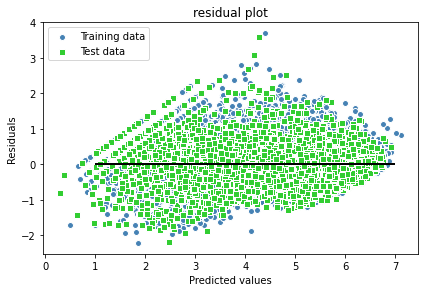

train ==============================
MSE:  0.345, RMSE:  0.587, R2:  0.829
test ==============================
MSE:  0.352, RMSE:  0.593, R2:  0.827


In [24]:
# Linear regression
slr = Pipeline( steps = [("std", StandardScaler()), 
                         ("regressor", LinearRegression())] )
slr.fit(X_train, y_train)

slr_tr_pred = slr.predict(X_train)
slr_te_pred = slr.predict(X_test)

plt.scatter(slr_tr_pred, slr_tr_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(slr_te_pred, slr_te_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=1, xmax=7, color='black', lw=2)
plt.tight_layout()
plt.title("residual plot")
plt.legend(loc='upper left')
plt.show()

print("train", "="*30)
evaluate(y_train, slr_tr_pred)
print("test", "="*30)
evaluate(y_test, slr_te_pred)

In [25]:
slr_scores = cross_val_score(estimator=slr,
                             X=X_train,
                             y=y_train,
                             cv=10, n_jobs=1)
print('CV accuracy scores: %s' % slr_scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(slr_scores), np.std(slr_scores)))

CV accuracy scores: [0.81316137 0.79825404 0.82961569 0.81640037 0.84179849 0.82726159
 0.83084231 0.83673262 0.83854915 0.82560791]
CV accuracy: 0.826 +/- 0.013


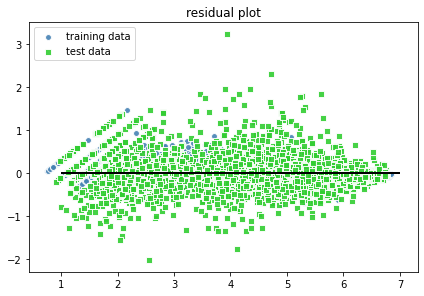

train ==============================
MSE:  0.019, RMSE:  0.137, R2:  0.991
test ==============================
MSE:  0.144, RMSE:  0.380, R2:  0.929


In [26]:
# RandomForest
rf = RandomForestRegressor()

rf.fit(X_train, y_train)
rf_tr_pred = rf.predict(X_train)
rf_te_pred = rf.predict(X_test)

plt.scatter(rf_tr_pred, rf_tr_pred - y_train, 
            c='steelblue', edgecolor='white', marker='o', s=35, alpha=0.9,
            label='training data')
plt.scatter(rf_te_pred, rf_te_pred - y_test, 
            c='limegreen', edgecolor='white', marker='s', s=35, alpha=0.9,
            label='test data')
plt.hlines(y=0, xmin=1, xmax=7, color='black', lw=2)
plt.tight_layout()
plt.title("residual plot")
plt.legend(loc='upper left')
plt.show()

print("train", "="*30)
evaluate(y_train, rf_tr_pred)
print("test", "="*30)
evaluate(y_test, rf_te_pred)

In [27]:
rf_scores = cross_val_score(estimator=rf,
                             X=X_train,
                             y=y_train,
                             cv=10, n_jobs=1)
print('CV accuracy scores: %s' % rf_scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(rf_scores), np.std(rf_scores)))

CV accuracy scores: [0.9180138  0.91107832 0.92766278 0.92734677 0.93473855 0.93264312
 0.93526676 0.93741062 0.94018298 0.93993956]
CV accuracy: 0.930 +/- 0.009


In [28]:
rf_pred = np.round(np.expm1(rf.predict(te)), 1)
rf_pred = pd.DataFrame(rf_pred, columns=['Rental bikes count'])
rf_pred.rename_axis('idx').reset_index()
# rf_pred
rf_pred.to_csv('rf_pred.csv', index=True, index_label='idx')

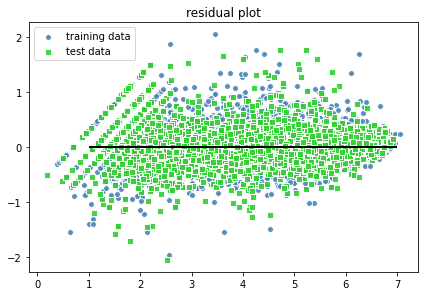

train ==============================
MSE:  0.075, RMSE:  0.274, R2:  0.963
test ==============================
MSE:  0.103, RMSE:  0.321, R2:  0.949


In [29]:
# Polynomial
plr = Pipeline( steps = [("std", StandardScaler()), 
                         ("poly", PolynomialFeatures(2)),
                         ("regressor", LinearRegression()) ] )
plr.fit(X_train, y_train)

plr_tr_pred = plr.predict(X_train)
plr_te_pred = plr.predict(X_test)

plt.scatter(plr_tr_pred, plr_tr_pred - y_train, 
            c='steelblue', edgecolor='white',marker='o', s=35,alpha=0.9,
            label='training data')
plt.scatter(plr_te_pred,  plr_te_pred - y_test, 
            c='limegreen',edgecolor='white',marker='s', s=35,alpha=0.9,
            label='test data')
plt.hlines(y=0, xmin=1, xmax=7, color='black', lw=2)
plt.tight_layout()
plt.title("residual plot")
plt.legend(loc='upper left')
plt.show()


print("train", "="*30)
evaluate(y_train, plr_tr_pred)
print("test", "="*30)
evaluate(y_test, plr_te_pred)

In [30]:
plr_pred = np.round(np.expm1(plr.predict(te)), 1)
plr_pred = pd.DataFrame(plr_pred, columns=['Rental bikes count'])
plr_pred.rename_axis('idx').reset_index()
plr_pred.to_csv('plr_pred.csv', index=True, index_label='idx')

In [31]:
plr_scores = cross_val_score(estimator=plr,
                             X=X_train,
                             y=y_train,
                             cv=10, n_jobs=1)
print('CV accuracy scores: %s' % plr_scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(plr_scores), np.std(plr_scores)))

CV accuracy scores: [0.94788376 0.9381705  0.94917242 0.94653413 0.95475758 0.95291865
 0.9485297  0.95366128 0.94674764 0.95457364]
CV accuracy: 0.949 +/- 0.005


#### Data pipeline with classification model

##### Binning train target values

Can be performed with ex. pandas.qcut or pandas.cut

```python
n_bins = 10
y_train_binned = pd.cut(y_train, n_bins, labels=False) # or
y_train_binned = pd.qcut(y_train, n_bins, labels=False) 
```

In [32]:
tmp_binned = [] 
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    y_binned = pd.cut(y, i, labels=False)
    X2 = tr.drop(['rental_bikes_count', 'weekday'], axis = 1)
    X2 = pd.get_dummies(X2, columns=['season', 'weather_situation'])
    
    X2_train, X2_test, y_train_binned, y_test_binned = train_test_split(
    X2, y_binned, test_size=0.15, random_state=0)
    
    rfc = RandomForestClassifier()
    rfc.fit(X2_train, y_train_binned)
    
    rfc_te_pred = rfc.predict(X2_test)
    
    # number of correct classification
    tenum_correct = (rfc_te_pred == y_test_binned).sum()
    # calculate the accuracy 
    te_accuracy = round(tenum_correct / X2_test.shape[0], 3)
    
    tmp_binned.append([i, tenum_correct, te_accuracy])

# Assign to dataframe        
res = pd.DataFrame(tmp_binned, columns =['binned', 'test_num_correct', 'test_accuracy'])
res

,binned,test_num_correct,test_accuracy
0,2,1687,0.956
1,3,1611,0.913
2,4,1524,0.864
3,5,1434,0.813
4,6,1377,0.781
5,7,1306,0.740
6,8,1281,0.726
7,9,1204,0.683
8,10,1121,0.635


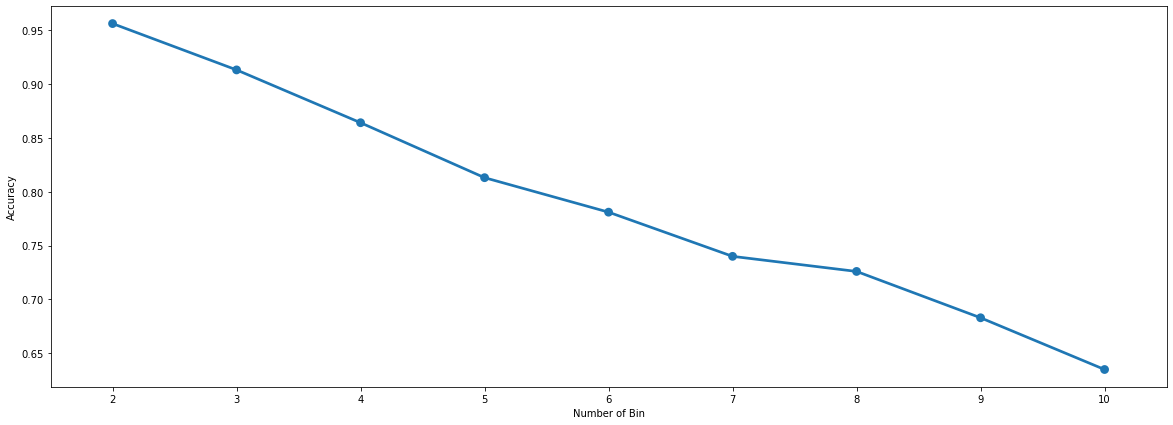

In [33]:
plt.figure(figsize = (20, 7)) 

sns.pointplot(data = res, x = "binned", y = "test_accuracy")
plt.xlabel("Number of Bin")
plt.ylabel("Accuracy")
plt.show()

It is clearly showing the accuracy is decreasing with the number of bins larger. It means that the model is hard to deal with the multinomial distribution.

#### Other models used for Kaggle submission

### Final Evaluation

In [34]:
# cross validation score
print('Linear regression CV accuracy: %.3f +/- %.3f' % (np.mean(slr_scores), np.std(slr_scores)))
print('Random Forest CV accuracy: %.3f +/- %.3f' % (np.mean(rf_scores), np.std(rf_scores)))
print('Polynomial CV accuracy: %.3f +/- %.3f' % (np.mean(plr_scores), np.std(plr_scores)))

Linear regression CV accuracy: 0.826 +/- 0.013
Random Forest CV accuracy: 0.930 +/- 0.009
Polynomial CV accuracy: 0.949 +/- 0.005


In this assignment, Polynomial has the highest accuracy among the models, however, the random forest has the highest score in Kaggle.

### Kaggle submission

Final Accuracy: 0.92056